<a href="https://colab.research.google.com/github/lapshinaaa/deep-learning-tasks/blob/main/DL5_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `Image Segmentation`

In this assignment, you will solve the task of segmenting people in photographs using the neural network architectures `U-Net` and `LinkNet`.

You can download the data for the task using the following [link](https://disk.yandex.ru/d/tI6d3LBMHTwOnw).

## `Loading Data`

To load data, PyTorch relies on an entity called a **`Dataset`**.

This abstract class is defined in `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
When defining a new data source, we create a subclass of this class and implement the methods `__getitem__` and `__len__`.

An example of an already implemented class is — `torchvision.datasets.ImageFolder`, which allows you to create a dataset based on a directory with an ImageNet-like subdirectory structure (`./train/{class}` and `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Implement `PhotosDataset` for our data.

In [1]:
import os

import numpy as np
import numpy.testing as npt
import random
import sys, importlib
import zipfile
import glob

import torch
from PIL import Image, ImageEnhance
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg13, VGG13_Weights
import torch.nn as nn
import torch.nn.functional as F
import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [ ]:
sys.path.insert(0, "/content")
importlib.invalidate_caches()

for zip_path in glob.glob("/content/*.zip"):
    print(f"Unzipping: {zip_path}")
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall("/content")
    os.remove(zip_path)
print("All zips extracted.")

Unzipping: /content/people_data.zip
All zips extracted.


In [ ]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images

        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.

        transforms : some collection
            Sequence of transformations for images and masks.
        """
        # your code here
        self.images_dir = images_dir
        self.target_dir = target_dir
        self.transforms = transforms

        self.image_names = sorted([
            fname for fname in os.listdir(images_dir)
            if fname.lower().endswith((".png", ".jpg", ".jpeg"))
        ])

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask

        Returns
        -------
        (image, mask)
        """
        # your code here
        # first, we're accessing the item
        img_name = self.image_names[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        # accessing masks
        mask = None
        if self.target_dir is not None:
            stem = os.path.splitext(img_name)[0]
            mask_path = os.path.join(self.target_dir, stem + ".png")
            mask = Image.open(mask_path).convert("L")

        if self.transforms: # apply transforms
            for transform in self.transforms:
                image, mask = transform(image, mask)

        return image, mask

## `Augmentation Module`

The standard `ImageFolder` constructor accepts a `transform` argument (and sometimes `target_transform`).

These arguments are used to transform loaded images (usually `PIL.Image`) or targets into tensors of the required format.

The `torchvision` package includes the `transforms` module, which provides standard examples of such transformations.
`Transforms` may include random transformations, which is the simplest way to implement data augmentation.

When defining a custom transformer, in addition to the constructor, it is sufficient to implement only the `call` method:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

A full list of standard transformations can be found in the [documentation](https://pytorch.org/vision/0.12/transforms.html).

In this part of the assignment, you are required to implement several custom data augmentation transformers.

Note that:

 • Some transformations must be applied to both the image and the mask

 • Some transformations must be applied only to the image

One possible implementation strategy:

 • Implement a decorator that makes any transformation random (applied with probability p)

 • Implement a decorator that applies a transformation to both the image and the mask

You need to implement the following transformations:
 1. Random horizontal flip of the image (applied with probability p)
 2. Random cutout (occlusion) of an image fragment (applied with probability p)
The fragment size may be fixed or random
 3. Random brightness adjustment of the image (applied with probability p)
The brightness change may be fixed or random
 4. Random background replacement (applied with probability p)
The background should be replaced with an image randomly selected from a given list of images

 • Use reasonable limits for augmentations. One common reason for poor model training is overly aggressive augmentations

 • Visually inspect augmented samples to ensure that edge cases remain realistic

 • Cutout means removing a part of the image (creating a hole), not cropping
If the image size changes after applying cutout, the module is implemented incorrectly

First, I'll implement two decorators and background collector

In [ ]:
def apply_to_mask(call_fn):  # decorator for applying transforms to mask as well
    def wrapper(self, img, mask=None):
        img = call_fn(self, img)
        if mask is not None:
            mask = call_fn(self, mask)
        return img, mask
    return wrapper

In [ ]:
# random application of transforms with probability p
class RandomApply:
    def __init__(self, transform, p=0.5):
        self.transform = transform
        self.p = p

    def __call__(self, img, mask=None):
        if random.random() < self.p:
            return self.transform(img, mask)
        return img, mask

In [ ]:
def extract_backgrounds(images_dir, masks_dir, max_bg=50):
    backgrounds = []

    for fname in os.listdir(images_dir):
        img_path = os.path.join(images_dir, fname)

        # split filename and extension
        stem = os.path.splitext(fname)[0]
        mask_path = os.path.join(masks_dir, stem + ".png") # because theu have diff formats

        if not os.path.exists(mask_path):
            continue  # safety check

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        img_np = np.array(img)
        mask_np = np.array(mask)

        bg = img_np.copy()
        bg[mask_np > 0] = 0  # remove person

        backgrounds.append(Image.fromarray(bg))

        if len(backgrounds) >= max_bg:
            break

    return backgrounds

#### Now, we'll implement the custom transforms:

In [ ]:
# random horizontal flip
class HorizontalFlip:
    @apply_to_mask
    def __call__(self, img):
        return img.transpose(Image.FLIP_LEFT_RIGHT)

In [ ]:
# random cutout
class Cutout:
    def __init__(self, min_frac=0.05, max_frac=0.2):
        self.min_frac = min_frac
        self.max_frac = max_frac

    @apply_to_mask
    def __call__(self, img):
        w, h = img.size

        cut_w = int(random.uniform(self.min_frac, self.max_frac) * w)
        cut_h = int(random.uniform(self.min_frac, self.max_frac) * h)

        x0 = random.randint(0, w - cut_w)
        y0 = random.randint(0, h - cut_h)

        img_np = np.array(img)
        img_np[y0:y0+cut_h, x0:x0+cut_w] = 0

        return Image.fromarray(img_np)

In [ ]:
# brightness adjustment
class BrightnessAdjust:
    def __init__(self, min_factor=0.7, max_factor=1.3):
        self.min_factor = min_factor
        self.max_factor = max_factor

    def __call__(self, img, mask=None): # we are not modifying the mask in this transform
        factor = random.uniform(self.min_factor, self.max_factor)
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(factor)
        return img, mask

In [ ]:
# background replacement
class BackgroundReplace:
    def __init__(self, background_images):
        """
        background_images: list of PIL.Images previously collected
        """
        self.backgrounds = background_images

    def __call__(self, img, mask):
        if mask is None:
            return img, mask

        bg = random.choice(self.backgrounds).resize(img.size)

        img_np = np.array(img)
        bg_np = np.array(bg)
        mask_np = np.array(mask)

        # foreground where mask > 0
        fg = mask_np > 0

        result = img_np.copy() # take original picture
        result[~fg] = bg_np[~fg] # for all pixels that are background, replace them with a diff background

        return Image.fromarray(result), mask

In [ ]:
DATA_PATH = "/content/people_data"

bg_images = extract_backgrounds(
    os.path.join(DATA_PATH, "train"),
    os.path.join(DATA_PATH, "train_mask")
)

In [ ]:
len(bg_images)

50

Add the augmentations to the dataset. Also, add tensor conversion and normalization:

```python
transforms.ToTensor()
transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
```

Tensor conversion and normalization:

In [ ]:
# tensor conversion
class ToTensor:
    def __call__(self, img, mask=None):
        img = np.array(img).transpose(2, 0, 1)
        img = torch.from_numpy(img).float() / 255.0

        if mask is not None:
            mask = torch.from_numpy(np.array(mask)).long()

        return img, mask

In [ ]:
# normalization
class Normalize:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def __call__(self, img, mask=None):
        mean = self.mean.to(img.device, img.dtype)
        std = self.std.to(img.device, img.dtype)
        img = (img - mean) / std
        return img, mask

In [ ]:
train_transforms = [
    RandomApply(HorizontalFlip(), p=0.5),
    RandomApply(Cutout(), p=0.3),
    RandomApply(BrightnessAdjust(), p=0.2),
    RandomApply(BackgroundReplace(bg_images), p=0.3),
    ToTensor(),
    Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
]

In [ ]:
test_transforms = [
    ToTensor(),
    Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
]

In [ ]:
train_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=train_transforms
)

test_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'test'),
    target_dir=os.path.join(DATA_PATH, 'test_mask'),
    transforms=test_transforms
)

In [ ]:
# len(train_dataset)

1350

Function for displaying images:

In [ ]:
def show_idx_image(dataset, idx):
    image, mask = dataset[idx]

    image = image.permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    mask = mask.squeeze(0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(6, 4))

    axes[0].imshow(image)
    axes[1].imshow(mask)

    axes[0].set_axis_off()
    axes[1].set_axis_off()

    fig.tight_layout()
    plt.show()

#### Visualization of Data Augmentations

Display several images and their corresponding masks that clearly demonstrate the correct operation of your data augmentation module.

Each augmentation module must be verified separately.  
If all augmentations are shown together without individual verification, points will be deducted.

**Important:**
Verify that the mask remains correct and properly aligned with the image after applying each augmentation.

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [ ]:
# flip transforms
flip_transforms = [
    RandomApply(HorizontalFlip(), p=1.0),  # force flip
    ToTensor(),
    Normalize(
        mean=mean,
        std=std
    )
]

flip_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=flip_transforms
)

In [ ]:
# len(flip_dataset)

1350

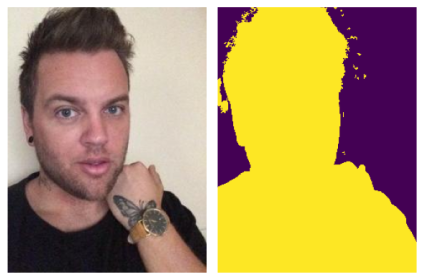

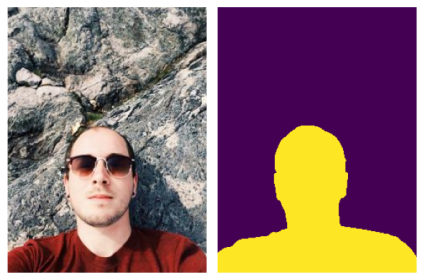

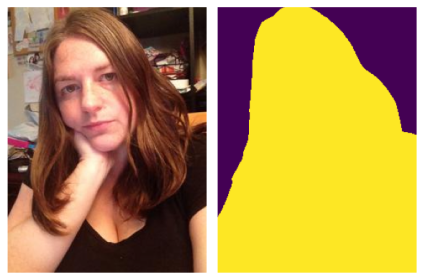

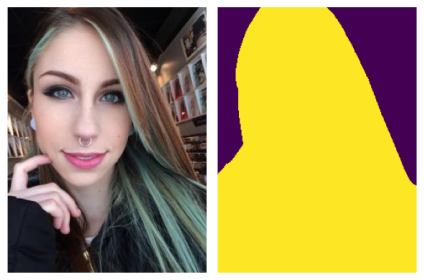

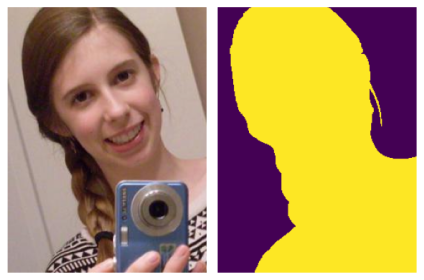

In [ ]:
for idx in random.sample(range(len(flip_dataset)), 5):
    show_idx_image(flip_dataset, idx)

In [ ]:
# cutout
cutout_transforms = [
    RandomApply(Cutout(), p=1),  # force cutout
    ToTensor(),
    Normalize(
        mean=mean,
        std=std
    )
]

cutout_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=cutout_transforms
)

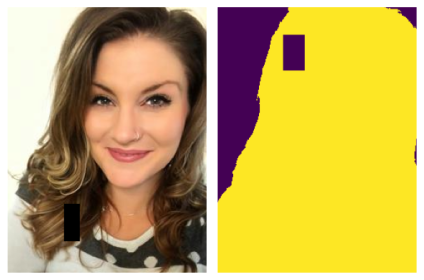

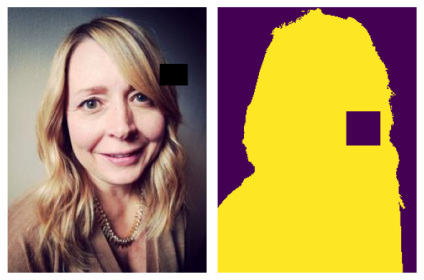

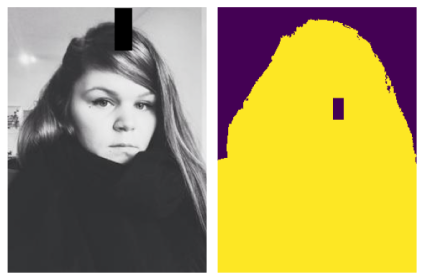

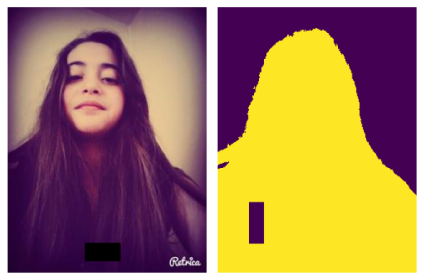

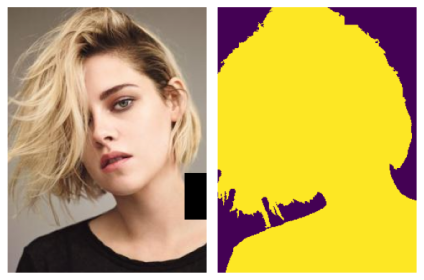

In [ ]:
for idx in random.sample(range(len(cutout_dataset)), 5):
    show_idx_image(cutout_dataset, idx)

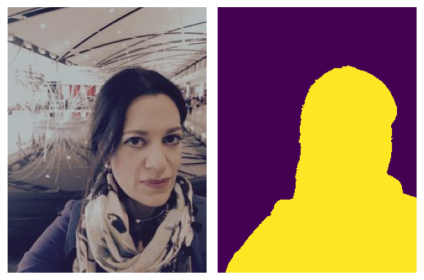

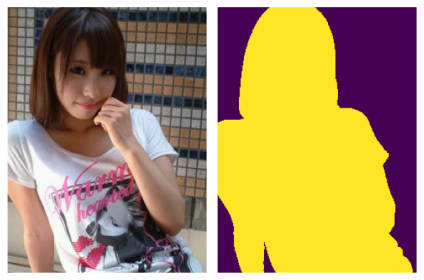

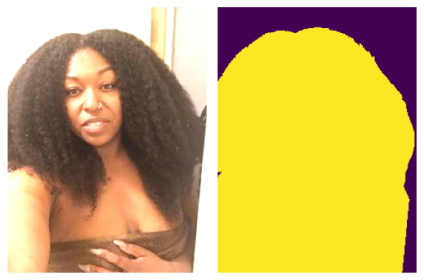

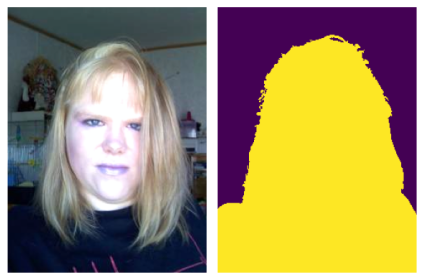

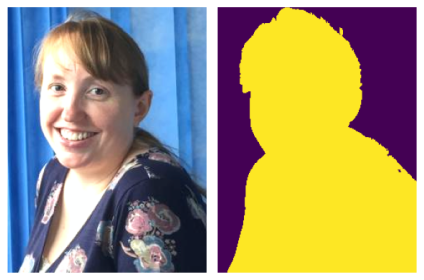

In [ ]:
# brightness
bright_transforms = [
    RandomApply(BrightnessAdjust(), p=1),  # force brightness transformation
    ToTensor(),
    Normalize(
        mean=mean,
        std=std
    )
]

bright_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=bright_transforms
)

for idx in random.sample(range(len(bright_dataset)), 5):
    show_idx_image(bright_dataset, idx)

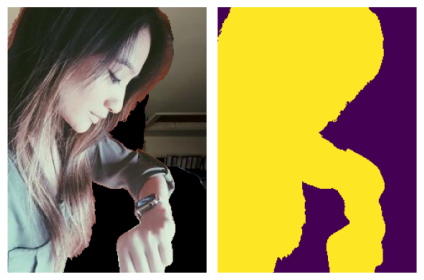

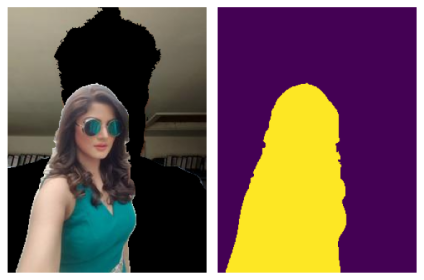

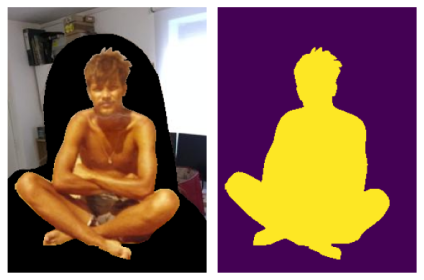

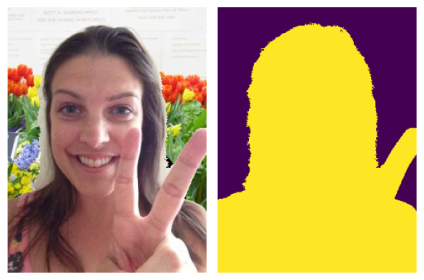

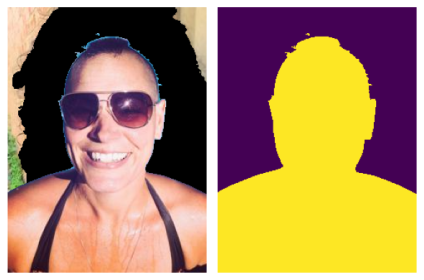

In [ ]:
# background replacement
bd_transforms = [
    RandomApply(BackgroundReplace(bg_images), p=1),  # force bd replacement
    ToTensor(),
    Normalize(
        mean=mean,
        std=std
    )
]

bd_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=bd_transforms
)

for idx in random.sample(range(len(bd_dataset)), 5):
    show_idx_image(bd_dataset, idx)

## `DataLoaders`

When training a neural network, it is more convenient to work not directly with datasets, but with data loaders.
Data loaders are created based on a dataset and allow iteration over the data in batches.

Pay attention to the parameters of `DataLoader`.
When `num_workers` $>$ 1, batches are prepared (images are loaded, processed, etc.) in several background processes simultaneously.
Using the shuffle parameter, images can be fed to the model in a random order during training.

Typically, the speed of data processing on the GPU exceeds the speed of data loading in a single process, therefore a common choice for
`num_workers` $\approx 3\text{-}10$.

Note that on some systems, when using Jupyter Notebook and `num_workers` $>$ 0, the DataLoader may stop working.
In such cases, set this value to $0$.

In [ ]:
test_data_loader = DataLoader(test_dataset, batch_size=8, num_workers=3)
train_data_loader = DataLoader(train_dataset, batch_size=8, num_workers=3, shuffle=True)

## `DiceLoss`

Loss function is implemented like other NN modules in pytorch through `torch.nn.Module`. In a cell below we'll implement a loss func `dice` (equivalent of Jaccard similarity).

Result of **Dice Loss** will define as:

$$
\text{Dice Coefficient} = 2\frac{|A \cap B| }{|A| + |B|} \leadsto \text{Dice Loss} = 1 - \frac{2\sum\limits_{i, j}a_{ij}b_{ij}}{\sum\limits_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

where $a_{ij} \in [0, 1]$ — predicted probability of finding a person in a pixel, $b_{ij}$ — true annotation of a pixel of an image.

In [ ]:
class DiceLoss(torch.nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:

            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed.
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits

    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        true_labels = true_labels.float()

        if self.with_logits:
            # your code here
            probs = torch.sigmoid(logits) # additional sigmoid for logits
        else:
          probs = logits

        probs = probs.view(probs.size(0), -1) # flatten
        true_labels = true_labels.view(true_labels.size(0), -1) # flatten

        # dice loss calc
        intersection = torch.sum(probs * true_labels, dim=1)
        union = torch.sum(probs + true_labels, dim=1)

        dice_loss = 1 - (2 * intersection + self.eps) / (union + self.eps)

        if self.reduction == 'sum':
            # your code here
            loss_value = dice_loss.sum()
        elif self.reduction == 'mean':
            # your code here
            loss_value = dice_loss.mean()
        elif self.reduction is None:
            # your code here
            loss_value = dice_loss

        return loss_value

Sanity check:

In [ ]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## `U-Net`

For the segmentation task we'll be using [U-Net](https://arxiv.org/pdf/1505.04597.pdf) with the encoder consisting of the first blocks of a pretrained `VGG13`.

A conceptual scheme is presented in the diagram below:

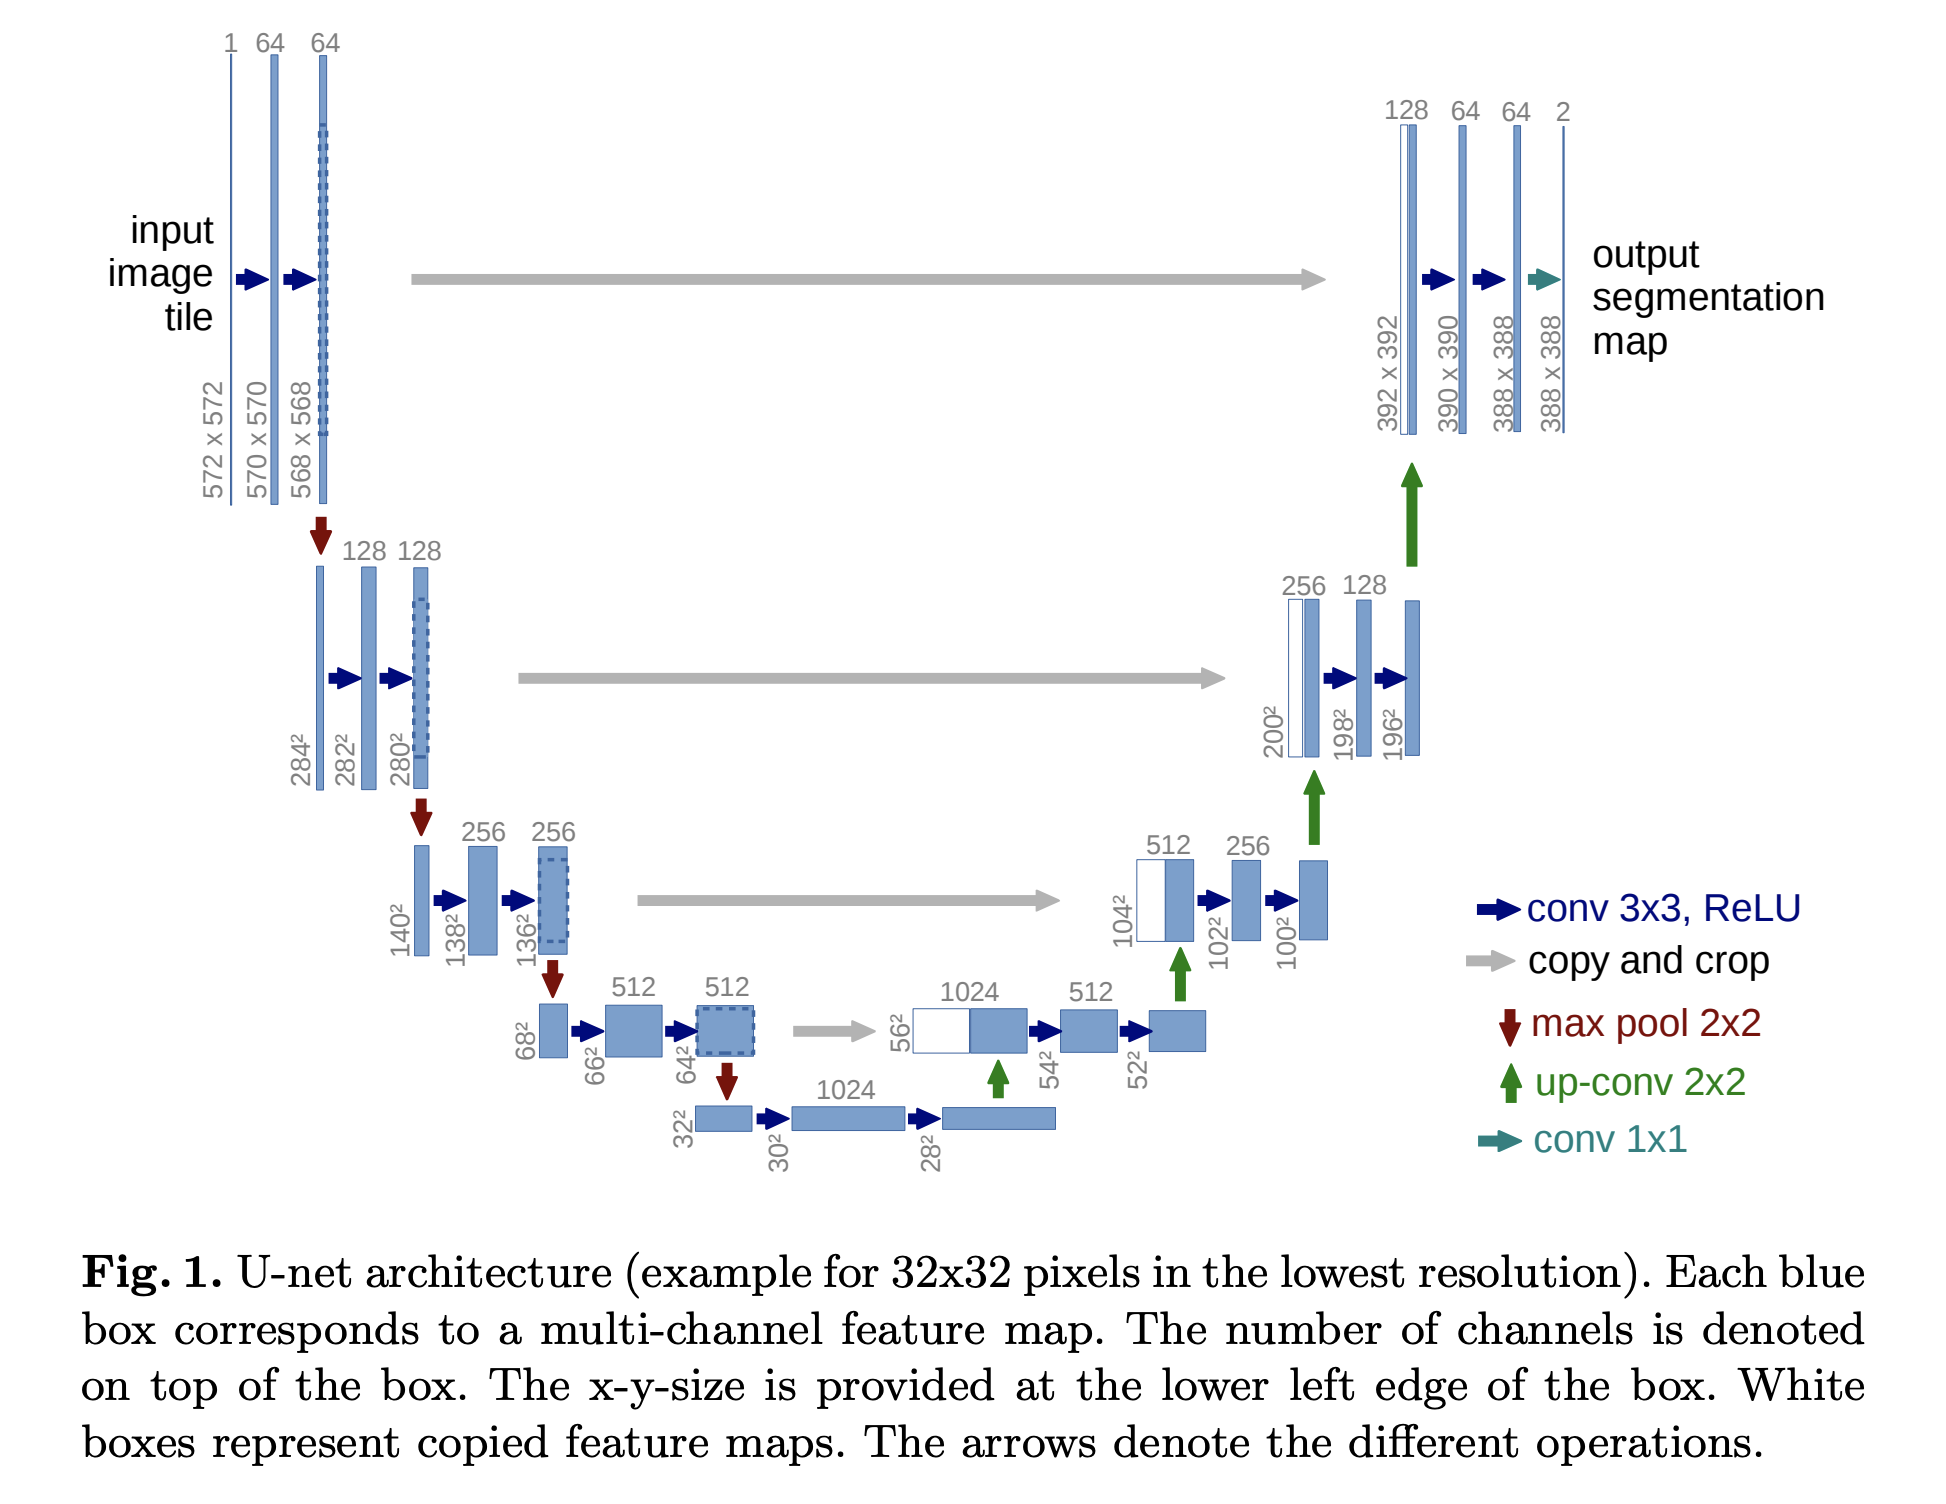

VGG13 blocks look the following way:
```python
    (0): Conv2d(...)
    (1): ReLU(...)
    (2): Conv2d(...)
    (3): ReLU(...)
    (4): MaxPool2d(...)
```

For convenience, we will remove the `MaxPool2d` layers from the encoder blocks and apply pooling separately.

In [ ]:
vgg13_model = vgg13(weights=VGG13_Weights.DEFAULT)

# taking a look at architecture
print(vgg13_model)

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth


100%|██████████| 508M/508M [00:13<00:00, 39.9MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

When implementing the `Decoder` we will need interpolation, for which `torch.nn.functional.interpolate` may be used with `mode=nearest`.

Implement the architecture of this Neural Network.

#### `Encoder`

In [ ]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, weights=VGG13_Weights.DEFAULT):
        super().__init__()
        self.num_blocks = num_blocks

        # VGG13 as a backbone
        feature_extractor = vgg13(weights=weights).features

        # each block of the U-Net encoder — is a block of VGG13 but just without MaxPool2d
        self.blocks = torch.nn.ModuleList()

        vgg_block_ranges = [(0, 4), (5, 9), (10, 14), (15, 19), (20, 24)]  # based on the arch above

        for idx in range(self.num_blocks):
            start, end = vgg_block_ranges[idx]

            self.blocks.append(
                # your code here
                torch.nn.Sequential(*feature_extractor[start:end])
            )

    def forward(self, x):
        activations = []
        for idx, block in enumerate(self.blocks):
            # apply conv+ U-Net
            # your code here
            x = block(x)

            # save activations before pooling for skip conn
            # your code here
            activations.append(x)

            # pooling
            # your code here
            x = F.max_pool2d(x, kernel_size=2, stride=2)

        return activations

In [ ]:
assert sum((param.numel() for param in VGG13Encoder(num_blocks=1).parameters())) == 38720
assert sum((param.numel() for param in VGG13Encoder(num_blocks=2).parameters())) == 260160
assert sum((param.numel() for param in VGG13Encoder(num_blocks=3).parameters())) == 1145408

x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)
out = VGG13Encoder(num_blocks=3)(x)

assert len(out) == 3
npt.assert_almost_equal(torch.linalg.norm(out[0]).item(), 902.218, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[1]).item(), 571.030, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[2]).item(), 648.068, decimal=3)

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth


100%|██████████| 508M/508M [00:07<00:00, 73.4MB/s]


#### `Decoder`

In [ ]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = torch.nn.ReLU()

    def forward(self, down, left):
        # Upsample x2 and conv
        # your code here
        x = F.interpolate(down, scale_factor=2, mode='nearest')
        x = self.upconv(x)

        # skip connection
        # your code here
        x = torch.cat([x, left], dim=1)

        # 2 convs + ReLu
        # your code here
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)

        return x

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, DecoderBlock(num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1]
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up

#### `U-Net`

In [ ]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=4):
        super().__init__()
        # your code here
        self.encoder = VGG13Encoder(num_blocks=num_blocks)

        # your code here
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks-1)

        # conv 1x1 for by-pixel channel aggregation
        # your code here
        self.final = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1) # 64 -> 2

    def forward(self, x):
        # your code here
        activations = self.encoder(x)
        x = self.decoder(activations)
        x = self.final(x)

        return x

In [ ]:
model = UNet(num_classes=1, num_blocks=3)

In [ ]:
#sum((param.numel() for param in model.parameters()))

2067649

In [ ]:
#list(model(x).shape)

[1, 1, 320, 240]

In [ ]:
x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)

assert sum((param.numel() for param in model.parameters())) == 2067649
assert list(model(x).shape) == [1, 1, 320, 240]
model

UNet(
  (encoder): VGG13Encoder(
    (blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0): DecoderBlock(
        (upconv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       

### `Quality Assessment`


Usually, the optimized loss function is hard to interpret, and different experiments may use different loss functions.  
Therefore, it is necessary to measure and track an independent quality metric.

We propose using `IoU (Intersection over Union `— one of the standard metrics for image segmentation:
$$
\text{IoU} = \frac{|A \cap B|}{|A \cup B|} = \frac{\sum\limits_{ij}a_{ij}b_{ij}}{\sum\limits_{ij}a_{ij} + b_{ij} - a_{ij}b_{ij}}
$$

Note that the denominator may be equal to zero, for example when the ground-truth mask is empty.  
Such samples can be ignored during aggregation, otherwise the metric computed over the whole batch will be NaN.

PyTorch provides built-in functions with the `nan` prefix to correctly handle such cases.


In [9]:
class IoUScore(torch.nn.Module):
    def __init__(self, threshold, reduction=None):
        """
        Arguments
        ---------
        threshold : float
            threshold for logits binarization
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:

            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed.
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()

        self.threshold = threshold
        self.reduction = reduction

    @torch.no_grad()
    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        # your code here
        preds = (logits > self.threshold).float() # binarized preds

        preds = preds.view(preds.size(0), -1) # flatten
        true_labels = true_labels.view(true_labels.size(0), -1).float() # flatten

        # IoU metric calc
        intersection = torch.sum(preds * true_labels, dim=1)
        union = torch.sum(preds + true_labels - preds * true_labels, dim=1)
        iou = intersection / union

        if self.reduction == 'sum':
            # your code here
            score = torch.nansum(iou)
        elif self.reduction == 'mean':
            # your code here
            score = torch.nanmean(iou)
        else:
            score=iou

        return score

In [10]:
logits = torch.tensor([
    [
        [0.3089,  0.4311, -0.9711],
        [0.9030,  1.0325, -0.7607],
        [0.9648, -0.5528, -1.1010]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ]
])
true_labels = torch.tensor([
    [
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]
    ], [
        [1., 1., 1.],
        [1., 0., 1.],
        [1., 0., 0.]
    ], [
        [1., 1., 1.],
        [0., 1., 1.],
        [1., 1., 1.]
    ]
])

scores = IoUScore(0.0)(logits, true_labels)
npt.assert_almost_equal(scores.numpy(), np.array([0.3333, 1.0000, 0.5556]), decimal=4)

score = IoUScore(0.0, reduction='sum')(logits, true_labels)
npt.assert_almost_equal(score.item(), 1.8889, decimal=4)

score = IoUScore(0.0, reduction='mean')(logits, true_labels)
npt.assert_almost_equal(score.item(), 0.6296, decimal=4)

### `Logging`

To monitor the training process, it is usually necessary to store information about different aspects of training.

For full control over training, it is common to log various statistics. The most obvious ones are:

1. Loss values on the training and validation (test) datasets  
2. Quality metrics, for example Dice Coefficient and IoU (Intersection over Union), on the training and validation datasets

However, surrogate metrics may not always reflect the true quality of the model. Therefore, for models that produce visualizable outputs, it is common to log model predictions for a subset of samples.

For the segmentation task, a natural choice is to log a quadruple:
- the original image
- the ground-truth mask
- the predicted probability mask of the positive class
- the binarized predicted mask

> Note: Loss and quality metrics on the training dataset are usually logged not only at the end of each epoch, but also per batch at each training iteration.

3. To track training dynamics, it is necessary to fix a small subset of samples from the training and validation datasets and, after each training epoch, log the four images listed above for each selected sample.

> Note: The four images can be logged independently, but it is more convenient to combine them into a single figure  
> [TensorBoard implementation](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_figure),  
> [WandB implementation](https://docs.wandb.ai/guides/track/log/plots/#matplotlib-and-plotly-plots)  
> (it is preferable to use a figure and Image).  
> An additional benefit is the ability to display metric values in the figure title or add a colorbar for easier interpretation of the predicted mask.

For convenient experiment categorization, it is common to log the following at the beginning of training:

4. Model hyperparameters  
   [TensorBoard implementation](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_hparams),  
   [WandB implementation](https://docs.wandb.ai/guides/track/config/)

5. Model architecture  
   [TensorBoard implementation](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_graph),  
   WandB implementation is described below

To study technical aspects of training, the following statistics are useful to log:

6. Distributions of weights, activations, and gradients  
   [TensorBoard implementation](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_histogram),  
   [WandB implementation](https://docs.wandb.ai/ref/python/data-types/histogram/)  

   Saving histograms for every parameter after each iteration may be computationally inefficient, so it is common to log weight distributions for each neural network layer after each epoch.

7. Weight norms and gradient norms at each iteration

Finally, after each epoch, intermediate representations of the input data can be visualized:

8. Activations after each layer or block, visualized as images  
9. Gradients of the loss with respect to activations for selected training samples, visualized as images

> Note: To implement items 8 and 9, it is not necessary to modify the model code.  
> Use hooks:  
> [register_full_backward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook)  
> (this hook does not work with inplace operations, for example torch.nn.ReLU(inplace=True). Either avoid inplace operations or use  
> [Tensor.register_hook](https://github.com/pytorch/pytorch/issues/61519)),  
> [register_forward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook).

### `Experiments`

Now let’s apply the network in practice!

Train the network on the training dataset and evaluate its performance on the test dataset.

First, during training, use only cross-entropy loss  
(`torch.nn.BCEWithLogitsLoss` is more convenient for the binary case).  
Record the obtained result.

Next, compare several optimization strategies:

1. Cross-entropy loss only
2. Dice loss only
3. Sum of both losses with weights  
   (try **3–4 different weight ratios**)

For all experiments:
- Plot the loss curves over training time
- Plot the quality metrics (e.g., Dice coefficient, IoU) over training time
- Visualize the predicted masks for several images from the dataset

Finally, draw conclusions based on the observed results.

In [ ]:
# your code here

## `LinkNet (2 балла)`

Реализуйте архитектуру [LinkNet](https://arxiv.org/pdf/1707.03718.pdf) с использованием энкодера, основанного на `VGG13`. Архитектура похожа на `Unet`, но вместо конкатенации слоёв используются skip-connections (сложения). Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

*Подсказка:* так как конкатенации слоёв заменили на skip-connections, то ожидается, что число параметров стало меньше.

**Обучите сеть и проведите анализ согласно предыдущему пункту. Сравните LinkNet и U-Net по качеству и скорости работы. Сделайте выводы.**

In [ ]:
# your code here

## `Теоретические вопросы (1 балл)`

### `Вопрос 1`
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура свёрточных сетей.
* Какие преимущества дает использование сверток в случае, если эти предположения верные?
* Приведите пример входных данных, когда эти предположения не выполняются.

*Ваш ответ в этой ячейке*

### `Вопрос 2`
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$.

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации.

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите:

1. Размерность выходного пространства.
2. Количество обучаемых параметров.
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

*Ваш ответ в этой ячейке*

## `Бонус: постобработка изображений (1 балл)`

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля [skimage.morphology](https://scikit-image.org/docs/dev/api/skimage.morphology.html)).

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстрируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## `Бонус: существенное улучшение качества (2 балла)`

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## `Бонус: обучение с использованием сторонних фреймворков (1 балл)`

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: [catalyst](https://github.com/catalyst-team/catalyst), [pytorch-lightning](https://www.pytorchlightning.ai/), [ignite](https://github.com/pytorch/ignite).

## `Бонус: аугментации (0.5 балла)`

Воспользуйтесь сторонними библиотеками для аугментаций, например, [deepaugment](https://github.com/barisozmen/deepaugment) и [albumentations](https://albumentations.ai/) для улучшения качества модели.